# 2022-08-29 • Visualizing subnets

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

Based on Roxin; same as previous nb's.

In [5]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
);

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [30]:
s = augment_simdata(s, p);

## Connection stats

conn matrix is [from, to].

So one row is all outputs of one neuron.

Summing over cols i.e. dim two gives num outputs.

In [23]:
num_out = count(s.is_connected, dims=2)
num_in = vec(count(s.is_connected, dims=1));

In [19]:
using PyPlot

In [20]:
using VoltoMapSim.Plot

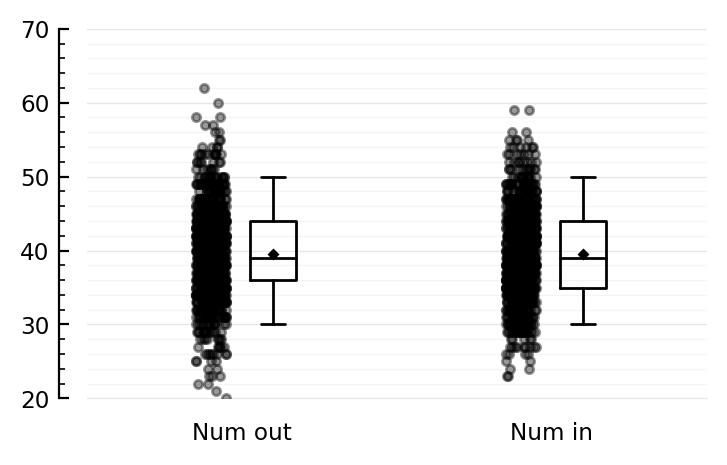

In [25]:
ydistplot("Num out" => num_out, "Num in" => num_in);

Sure yes, 40 = 1000 * 0.04.

Let's export to Graphviz dot, to explore viz options with Gephi.

In [73]:
lines = ["digraph {"]
for id in s.neuron_IDs
    outputs = join(s.output_neurons[id], ", ")
    type = s.neuron_type[id]
    push!(lines, "   $(id) [type = $(type)]")
    push!(lines, "   $(id) -> {$(outputs)}")
end
push!(lines, "}")
dot = join(lines, "\n")
lines[[1:5; end-2:end]]

8-element Vector{String}:
 "digraph {"
 "   1 [type = exc]"
 "   1 -> {9, 10, 13, 19, 35, 55," ⋯ 121 bytes ⋯ "832, 861, 917, 942, 967, 1000}"
 "   2 [type = exc]"
 "   2 -> {62, 70, 100, 127, 185," ⋯ 110 bytes ⋯ " 765, 831, 885, 893, 900, 930}"
 "   1000 [type = inh]"
 "   1000 -> {16, 23, 60, 148, 18" ⋯ 182 bytes ⋯ " 873, 885, 929, 955, 973, 976}"
 "}"

In [74]:
open(joinpath(homedir(), ".phdcache", "graph.dot"), "w") do io
    println(io, dot)
end

Nice! Graphviz, fun.

![](images/gephi.png)

All 1000 neurons are drawn (inhibitory in red). The highlighted neurons are the inputs and outputs of one neuron.

Now I want only a subset of the net.
Say: 1, 801, and their inputs and outputs.

In [80]:
lines = ["digraph {"]
for m in [1, 801]
    t = s.neuron_type[m]
    push!(lines, "   $m [type = $t]")
    for n in s.input_neurons[m]
        t = s.neuron_type[n]
        push!(lines, "   $n [type = $t]")
        push!(lines, "   $n -> $m")
    end
    for n in s.output_neurons[m]
        t = s.neuron_type[n]
        push!(lines, "   $n [type = $t]")
        push!(lines, "   $m -> $n")
    end
end
push!(lines, "}")
open(joinpath(homedir(), ".phdcache", "graph.dot"), "w") do io
    println(io, join(lines, "\n"))
end

Seems like gephi can't handle `{…} -> ` format alas. So all inputs on sep line.

![](images/gephi-1-801.png)

(Yifan Hu layout with default settings)

So these two random neurons have 7 disynaptic connections between them:
2 from the exc (`1`, left) to the inh (`801`, right); and 5 from the inh to the exc. All 7 pass through an excitatory neuron.

Same but using graphviz as layouter:

![](images/graphviz-1-801.svg)

(Open in new tab to see full size).